# UNET


* Prepare image input
* Implement UNET
* Optimise the hyperparameters
* K-Fold validation

In [1]:
# Load libraries
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision.all import *
import torch
from ipywidgets import IntProgress
from glob import glob
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import cv2, os
from fastai.distributed import *
# always check if the GPUS are available - sometimes they come off for no reason
torch.cuda.is_available()

True

# KFOLD

In [2]:
# # functions for kfold and datablocks
# def label_func(fn): 
#     return path/"labels"/f"{fn.stem.replace('image', 'mask')}{fn.suffix}"

# def fname_folds(fold=0):
#     def __inner(path, fold=0):
#         fnames = get_image_files(path)
#         from sklearn.model_selection import KFold
#         kfold = KFold(n_splits=5, shuffle=True, random_state=33)
#         kfold_ds = {}
#         i=0
#         for ti, vi in kfold.split(fnames):
#             kfold_ds[i] = fnames[ti] + fnames[vi]
#             i+=1
#         return kfold_ds[fold]
#     return __inner

# def KfoldSplitter(valid_pct=0.2, seed=None): 
#     def _inner(o):
#         if seed is not None: torch.manual_seed(seed)
#         rand_idx = L(list(torch.randperm(len(o)).numpy()))
#         cut = int(valid_pct * len(o))
#         return rand_idx[cut:], rand_idx[:cut]
#     return _inner

In [4]:
codes = np.loadtxt("/data/weed_data/inputImages_Masks/codes.txt", dtype='str')
path = Path('/data/weed_data/inputImages_Masks/train_val_set/')

In [18]:
fnames = glob('/data/weed_data/inputImages_Masks/train_val_set/*')
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=33)
kfold_ds = {}
i=0
for ti, vi in kfold.split(fnames):
    kfold_ds[i] = fnames[ti] + fnames[vi]
    i+=1
    
kfold_ds

TypeError: only integer scalar arrays can be converted to a scalar index

In [14]:
kfold_ds[1]

(#18342) [Path('/data/weed_data/inputImages_Masks/train_val_set/images/g1_DJI_0031_image_32.png'),Path('/data/weed_data/inputImages_Masks/train_val_set/images/g1_DJI_0078_image_18.png'),Path('/data/weed_data/inputImages_Masks/train_val_set/images/e1_a05f2d208dd64ff80c01_image_8.png'),Path('/data/weed_data/inputImages_Masks/train_val_set/images/g1_DJI_0012_image_59.png'),Path('/data/weed_data/inputImages_Masks/train_val_set/images/e1_5bae451d8a2788c9e0f1_image_11.png'),Path('/data/weed_data/inputImages_Masks/train_val_set/images/e1_eff0042662c4fb4fb1c5_image_5.png'),Path('/data/weed_data/inputImages_Masks/train_val_set/images/g1_DJI_0013_image_28.png'),Path('/data/weed_data/inputImages_Masks/train_val_set/images/g1_DJI_0097_image_20.png'),Path('/data/weed_data/inputImages_Masks/train_val_set/images/g1_DJI_0073_image_15.png'),Path('/data/weed_data/inputImages_Masks/train_val_set/images/g1_DJI_0033_image_36.png')...]

In [121]:
# do the thing
results = {"val_loss":[],
          "dice":[],
          "iou":[]}

for i in range(1):
    # do kfold validation
    weedt = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = fname_folds(fold=i),
                   get_y = label_func,
                   splitter=KfoldSplitter(valid_pct=0.2, seed=100),
                   item_tfms=FlipItem,
                   batch_tfms=RandomResizedCrop(500))
    dls = weedt.dataloaders(path/"images", path=path, bs=4)

    # loss function could be Diceloss (most used)
    learn = unet_learner(dls, 
                     resnet18,
                     n_out=3,
                     self_attention=True,
                     normalize=True,
                     pretrained=True,
                     loss_func=DiceLoss(), 
                     opt_func=Adam,
                     lr= 0.001,
                     wd=None,
                     metrics=[DiceMulti, JaccardCoeff])
    
    # Disable Fastai progress bar
    with learn.no_bar()and learn.no_logging():
            learn.fit_one_cycle(1, 0.001)
    
    # returns the [val loss, Dice_multi, Jaccard's index]
    results["val_loss"].append(learn.validate()[0])
    results["dice"].append(learn.validate()[1])
    results["iou"].append(learn.validate()[2])
    
    opath = "/nbs_dir/weed_detectionAHRI/blues_lupins/model_nbs/"
    with open(f"{opath}unet18_kfold.txt", "wb") as ot:
         pickle.dump(results, ot)

/home/modanilevicz/.local/lib/python3.8/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


TypeError: write() argument must be str, not bytes

In [125]:
with open(f"{opath}unet18_kfold.txt", "wb") as ot:
         pickle.dump(results, ot)

In [126]:
with open(f"{opath}unet18_kfold.txt", 'rb') as f:
    loaded_dict = pickle.load(f)
loaded_dict

{'val_loss': [3.42187762260437],
 'dice': [0.9008071110279454],
 'iou': [1.0754447654562371]}

# Testing functions separately


If I change the images to jpeg, would it all work out of the box?


In [2]:
codes = np.loadtxt("/data/weed_data/inputImages_Masks/codes.txt", dtype='str')
path = Path('/data/weed_data/inputImages_Masks/train_val_set/')

In [3]:
def label_func(fn): 
    return path/"labels"/f"{fn.stem.replace('image', 'mask')}{fn.suffix}"

In [4]:
weedt = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(valid_pct=0.2, seed=100))

/home/modanilevicz/.local/lib/python3.8/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


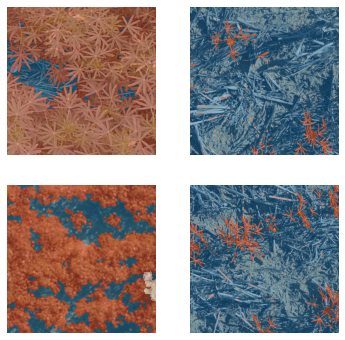

In [5]:
dls = weedt.dataloaders(path/"images", path=path, bs=4)
dls.show_batch(max_n=4)

In [25]:
# loss function could be Diceloss (most used), Focal loss (ensures low class imbalance)
learn = unet_learner(dls, 
                     resnet34,
                     n_out=3,
                     self_attention=True,
                     normalize=True,
                     pretrained=True,
                     loss_func=DiceLoss(), 
                     opt_func=Adam,
                     lr= 0.001,
                     wd=None,
                     metrics=[DiceMulti, JaccardCoeff]).to_fp16()
# is unet pretrained? tune hyperparameters

LR before training 0.0012022644514217973


epoch,train_loss,valid_loss,dice_multi,jaccard_coeff,time
0,3.463119,3.439619,0.879243,1.060088,14:20


LR after defreezing 9.12010818865383e-07


epoch,train_loss,valid_loss,dice_multi,jaccard_coeff,time
0,1.430337,1.549426,0.659087,1.007917,15:08
1,1.356406,1.519959,0.659820,1.009865,15:09


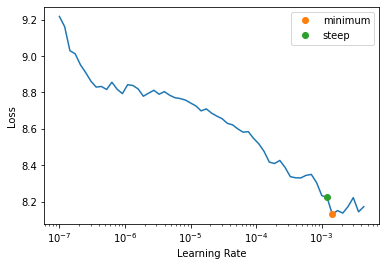

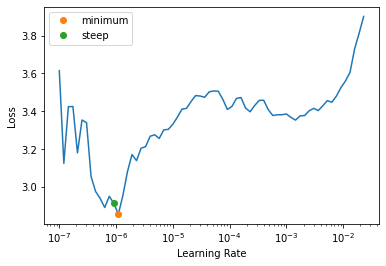

In [26]:
# Disable Fastai progress bar
with learn.no_bar()and learn.distrib_ctx():
    lr_min1,lr_steep1 = learn.lr_find(suggest_funcs=(minimum, steep), show_plot=False)
    print(f"LR before training {lr_steep1}")
    learn.fit_one_cycle(1, lr_steep1)
    
    lr_min2,lr_steep2 = learn.lr_find(suggest_funcs=(minimum, steep), show_plot=False)
    print(f"LR after defreezing {lr_steep2}")
    
    learn.unfreeze()
    learn.fit_one_cycle(2,
                        lr_max= slice(lr_steep2, lr_steep1), 
                        cbs=CSVLogger(fname='unet18_kfold_pretrained' append=True))

In [27]:
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAYIAAAEKCAYAAAAfGVI8AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjQuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8rg+JYAAAACXBIWXMAAAsTAAALEwEAmpwYAAA5dElEQVR4nO3dd3zU9f3A8df7LrkL2WQxwgp7hBFAZIiCiFAHonXU0Wq1tbXOOmr7s7VqbWtb66pKta1FW7UiaouzlhZEUPYMO+wQIItssi6f3x93iUm4JBeSG7l7Px+PPLz73ve+3/eHmHvfZ4sxBqWUUqHL4u8AlFJK+ZcmAqWUCnGaCJRSKsRpIlBKqRCniUAppUKcJgKllApxYf4OoL2SkpLMgAED/B2GUkp1KRs2bMg3xiS7e63LJYIBAwawfv16f4ehlFJdiogcauk1bRpSSqkQp4lAKaVCnCYCpZQKcV2uj8CdmpoasrOzqays9HcoXVpERAR9+vQhPDzc36EopXwoKBJBdnY2MTExDBgwABHxdzhdkjGGgoICsrOzSUtL83c4SikfCoqmocrKShITEzUJdICIkJiYqLUqpUJQUCQCQJNAJ9B/Q6UC1782HyW31Dtf1IImEXQFS5Ys4Yknnmj1nJycHK688kofRaSU6goOFZRz9z8280nmca9cPyj6CNpt6yL472NQnA1xfWDWwzDmaq/fdt68ecybN6/Vc3r37s3ixYu9HotSquv4fG8+AOcMTvLK9UOvRrB1Ebx/FxQfAYzzv+/f5TzeAQcPHmT48OHcdNNNDB06lOuvv56lS5cybdo0hgwZwtq1a1m4cCF33HEHADfddBN33XUXU6dOZeDAgQ0f/gcPHiQ9PR2AhQsXMn/+fGbPns2AAQN4/vnneeqpp8jIyGDy5MkUFhYCMGPGjIbZ1vn5+dQvweHp+5VSgW3l3nxS47uRlhTlleuHXiL472NQc6rpsZpTzuMdlJWVxX333ceuXbvYtWsXb7zxBitXruTJJ5/kV7/61WnnHzt2jJUrV/LBBx/w4x//2O01MzMzeffdd1m3bh0PPfQQkZGRbNq0iSlTpvDaa6+1GVNH36+U8i9HneGLffmcMzjJa/14oZcIirPbd7wd0tLSGD16NBaLhVGjRjFr1ixEhNGjR3Pw4MHTzp8/fz4Wi4WRI0dy4sQJt9ecOXMmMTExJCcnExcXx6WXXgrQ4jU7+/1KKf/aml1ESWUt5wzxTrMQhGIiiOvTvuPtYLfbGx5bLJaG5xaLhdra2lbPN8ac8TXDwsKoq6sDOG34Z3tjUkoFlpV78xGBaV7qH4BQTASzHobwbk2PhXdzHu+iBgwYwIYNGwC0o1mpIPN5Vj6jeseSEGXz2j1CLxGMuRoufQ7i+gLi/O+lz/lk1JC33H///SxYsICMjAzy8/P9HY5SqpOUV9Wy6fBJzhnsdhuBTiMtNUkEqokTJ5rm+xHs3LmTESNG+Cmi4KL/lkoFjv/tOsHNC9fz+nfO7nDTkIhsMMZMdPda6NUIlFKqi/h8bz72MAsT+nf36n00ESilVIBauTefSWkJRIRbvXofTQRKKRWAjhdXsje3jOleHDZaTxOBUkoFoJVZ9ctKeLejGDQRKKVUQFq5N4+kaBvDe8Z4/V6aCJRSKsAYY1iZVcC0wUlYLN5fHl4TgRc988wzVFRU+DsMpVQXs+t4KfllVV5bbbQ5ryUCEYkQkbUiskVEtovIo27O6Sciy0Rkk4hsFZGLvBVPYx/u/5ALF1/ImFfHcOHiC/lw/4deuY8mAqXUmVjpWnZ6+hDv9w+Ad2sEVcD5xpixwDhgrohMbnbOT4FFxpgM4BvAi16MB3AmgUe+eIRj5ccwGI6VH+ORLx7pcDIoLy/n4osvZuzYsaSnp/Poo4+Sk5PDzJkzmTlzJgCffvopU6ZMYfz48Vx11VWUlZUBsGHDBs477zwmTJjAnDlzOHbsGOBcXvruu+9m3LhxpKens3bt2o4VXinVJazYm8fglGh6xkX45H5eSwTGqcz1NNz103waswFiXY/jgBxvxVPv2Y3PUuloujBbpaOSZzc+26HrfvLJJ/Tu3ZstW7aQmZnJPffcQ+/evVm2bBnLli0jPz+fxx9/nKVLl7Jx40YmTpzIU089RU1NDXfeeSeLFy9mw4YN3HzzzTz00EMN162oqGDz5s28+OKL3HzzzR2KUSkV+Mqralmzv5CZw3xTGwAv71AmIlZgAzAYeMEYs6bZKY8An4rInUAUcIE34wE4Xu5+q7eWjntq9OjR3HfffTz44INccsklTJ8+vcnrq1evZseOHUybNg2A6upqpkyZwu7du8nMzGT27NkAOBwOevXq1fC+a6+9FoBzzz2XkpISioqKiI+P71CsSqnA9cW+AqoddcwcluKze3o1ERhjHMA4EYkH3hORdGNMZqNTrgUWGmN+LyJTgL+5zqlrfB0RuRW4FaBfv34diqlnVE+OlR9ze7wjhg4dysaNG/noo4/46U9/yqxZs5q8boxh9uzZvPnmm02Ob9u2jVGjRvHll1+6vW7zjSh0g3mlgtuy3blE2axMHJDgs3v6ZNSQMaYIWAbMbfbSLcAi1zlfAhHAad3kxpiXjTETjTETk5M7Vl26e/zdRFibtrtFWCO4e/zdHbpuTk4OkZGR3HDDDTzwwANs3LiRmJgYSktLAZg8eTKrVq0iKysLcPYp7Nmzh2HDhpGXl9eQCGpqati+fXvDdd966y0AVq5cSVxcHHFxcR2KUykVuIwxLN+VyzlDkrCF+W5Qp9dqBCKSDNQYY4pEpBswG/hNs9MOA7OAhSIyAmciyPNWTAAXD7wYcPYVHC8/Ts+ontw9/u6G42dq27ZtPPDAA1gsFsLDw1mwYAFffvklc+fObegrWLhwIddeey1VVVUAPP744wwdOpTFixdz1113UVxcTG1tLffccw+jRo0CICIigoyMDGpqanjllVc6VnilVEDbc6KMnOJK7po1xKf39doy1CIyBngVsOKseSwyxjwmIo8B640xS0RkJPAnIBpnx/GPjDGftnbdUFqGesaMGTz55JNMnOh25VivCNZ/S6W6gj9+to8nPt7F6p/M6vQRQ60tQ+21GoExZiuQ4eb4w40e7wCmeSsGpZTqSpbvzmVEr1ifDRut59XOYtUxy5cv93cISikfKamsYf3Bk9x67kCf31uXmFBKqQCwam8+tXWGmcN9N2y0XtAkgq625WYg0n9Dpfxn2e5cYiPCyOgb7/N7B0UiiIiIoKCgQD/IOsAYQ0FBARERvm2bVEo5//6W7c5j+tBkwqy+/1gOij6CPn36kJ2dTV6eV0eeBr2IiAj69Onj7zCUCjnbc0rIK63y6WzixoIiEYSHh5OWlubvMJRS6ows350LwHlDfbe+UGNB0TSklFJd2bLdeYzpE0dyjN0v99dEoJRSflRUUc2mwyeZ4admIdBEoJRSfrXpSBF1BqYOSvRbDJoIlFLKj7YfLQZgVO/YNs70Hk0ESinlR5lHS0hLiiImItxvMWgiUEopP8rMKfZrbQA0ESillN8UVVSTffIUo3r7d58RTQRKKeUn23NKAEhP1RqBUkqFpO059R3FWiNQSqmQlHm0hNT4biRE2fwahyYCpZTyk0DoKAZNBEop5RdlVbUcyC8nPdW/zUKgiUAppfxi57ESjPF/RzFoIlBKKb/IPBoYHcWgiUAppfwi82gJSdF2Uvy04mhjmgiUUsoPtucUk54ai4j4OxRNBEop5WuVNQ725paRHgDNQqCJQCmlfG7X8VIcdSYgOopBE4FSSvlcoMworqeJQCmlfCzzaAlx3cLp072bv0MBNBEopZTPBVJHMWgiUEopn6px1LHrWGnANAtBCCUCYwyVNQ6MMf4ORSkVwvaeKKPaURcQawzV81oiEJEIEVkrIltEZLuIPNrCeVeLyA7XOW94K54Fn+1j+M8+oaq2zlu3UEqpNmW6OooDYY2hemFevHYVcL4xpkxEwoGVIvKxMWZ1/QkiMgT4CTDNGHNSRFK8FUyUzVnUimoHEeFWb91GKaVatf1oMVE2K2mJUf4OpYHXagTGqcz1NNz107xd5rvAC8aYk6735Hornkib88O/vKrWW7dQSqlWVdU6WLozl7F947FYAqOjGLzcRyAiVhHZDOQC/zHGrGl2ylBgqIisEpHVIjK3hevcKiLrRWR9Xl7eGcUSbXfWCMqrNREopfzj9dWHOVp0ih/MGOzvUJrwaiIwxjiMMeOAPsAkEUlvdkoYMASYAVwL/ElE4t1c52VjzERjzMTk5OQziiWqPhFojUAp5QdlVbU8vyyLqYMSOWdIkr/DacIno4aMMUXAMqD5N/5sYIkxpsYYcwDYgzMxdLoou7NpqKzK4Y3LK6VUq/7y+QEKy6v50dzh/g7lNN4cNZRc/+1eRLoBs4FdzU77J87aACKShLOpaL834qmvEVRojUAp5WOF5dX86fP9zB3Vk3F94/0dzmm8OWqoF/CqiFhxJpxFxpgPROQxYL0xZgnwb+BCEdkBOIAHjDEF3gimftRQmSYCpZSPvbgsi4rqWu6fM9TfobjltURgjNkKZLg5/nCjxwa41/XjVQ01gmptGlJK+c7RolO8tvoQXx/fh8EpMf4Ox62QmVlcP3xUawRKKV96dukeMHDP7MCsDUAIJQJ7mIUwi1Chw0eVUj6y+3gpizdk880p/UmND4yVRt0JmUQgIkTarJTrqCGllA/UOOq47+3NdI+0cfvMwJo30Jw3O4sDTrQ9TOcRKKV84oVlWWQeLeGPN4wnIcrm73BaFTI1AoBIe5jOLFZKeV3m0WKe/18Wl2ekMje9l7/DaVNIJYIoe5hOKFNKeVVVrYN7F20mMdrGI5eO8nc4HgmxpiGrTihTSnnV0//Zy54TZSz89lnERYb7OxyPhFSNINIWpsNHlVJes+FQIS+v2Me1k/oyY5jXVtXvdCGVCKLtYTqhTCnlFbWOOh58Zxu94rrx0MUj/R1Ou4RUInAOH9UagVKq8y3ekE1Wbhk/u2Rkw7L3XUVIJYJoHTWklPKCyhoHzyzdS0a/eOaM6uHvcNqta6WtDoq0hVFZU0eto44wa0jlQOVFtY46svLK2JZdzPacEnYcKwED0RFhRNvDiI4IY2SvWK4/ux8igbMrleo8C784yPGSSp75xrgu+TsOqURQvydBRY2DWE0EqhP8acV+nvx0N1W1dYCz+XFEr1jCrUJuaSX78mopPlXDG2sOkxJj58JRPf0csepsxRU1vLgsi5nDkpk8MNHf4ZyREEsEX+1SFhvRNYZ1qcD18bZj/PKjncwclsz8jFRG9Y4jLSkKa7O9aGscdcx9ZgVPfLyLmcNTCNcvIUFlwWf7KK2qDcgNZzwVUv9H6naVqrNkHi3mh4s2M75fPAtumMBl41IZnBJ9WhIACLda+MnXRrA/v5w31x72Q7TKW44XV/LXVQeYPy6VEb1i/R3OGQupRBDtahrSheeUO7mlleSWVuKoM62fV1LJd15dT2KUnZe+OZGIcGub1541IoXJAxN4ZuleSiprOitk5WfPLN1DnTHcG8BLTHsipJqGIm1aI1DufZJ5jB+8vpE6A1aLkBxtp0esnYHJ0UwfksT0Ickkx9iprHHw3b9toKSyhsXfn0pyjN2j64sID100kkufX8kfl+/r0s0IymnviVIWrT/Ct6YMoG9CpL/D6ZCQSgT1Y3vLdVKZauRQQTkPvL2V9NQ4rprQhxMlVZwoqeR4SSWf783jvU1HAUhPjaVbuJUtR4p46ZsTGNm7fU0Bo/vEcXlGKn9ZeYDrJ3d8fXpjDIcLK4jvZusySxkEi8oaB3e+uYm4buHccX5gLzHtiZBKBPW7lGmNQNWrrHFw+xsbsViEF64bf9o3u7o6w45jJXy2J4/Pduex8fBJHpw7nDlnOPrn/jnD+HDbMX7/7908dc24dr3XGMOnO06w8dBJth0tJvNoMSWVtYxOjWPJHdO65LDFrurxD3ew63gpr9w0kaRoz2qFgSykEsFXNQJNBMrp8Q93kHm0hD9/a6Lb6r3FIqSnxpGeGsftMwfjqDNuO4Q9lRrfjVvOSWPB8n3cfE4a6alxHr/3lVUH+cUHOwi3CsN7xnLJ2N44HIa31h9h7YFCzu6iQxe7mg+3HuPvqw9z67kDOX9415s85k5IJYJIHTWkGvnX5qP8ffVhvnfuQC4Y6dkfdEeSQL3bZgziH2sP89R/9vDKTWd59J7C8mqeXbqH6UOS+MuNZ2ELc47zOFXt4N87jrPwi4MdSgSF5dWs2JNHZY2DakcdVTV11NYZLs9IpWdcxBlftyurqnVgD2s6EOBwQQU/fmcr4/rGc/+Fw/wUWecLrUQQrqOGlNO+vDL+791tTOjfnfvn+PYPOjYinBunDuCZpXvJyi1lcEpMm+95Zukeyqsd/OySkQ1JAKCbzco3zurHyyv2kX2ygj7d299pebK8misXfMH+/PLTXsvMKeaF68a3+5pd3W8+2cXLK/YzdVAil47pzYWjehBpC+OONzeCwB+uzWjye+jqgqckHrBYRBeeU9Q46rjrzU3Ywiw8f12GXyZ4fXNyf+xhFv78+YE2z917opTX1xzmukn9GNrj9KTxzSn9ERH+9uWhdsdRWePgO6+tJ7voFK/cNJEvf3I+G356AZmPzuH75w3io23HyMota/d1u7KFqw6wYPk+Jg9M4FBBBT96ZysTH1/KRc99ztbsYn535ZguP0qouZBKBOCcVKZ9BKHthWVZbM8p4ddXjKFXXMdG7pypxGg7V07ow7sbj5JbWtnquY9/uJNIm5UftjBWPTW+G3NG9eDNtYepaMf/2446ww/f2szGwyd5+upxnD+8B73iupEYbSfaHsZ3p6dhD7OwYPm+dpWtK/sk8ziPfrCD2SN78NrNZ/PZAzN4/45zuGV6Go46w/fOG9gltp5sr9BLBDarNg2FsO05zr1kLxvXm7np/l3355Zz0qipq2v1m/yy3bl8tiePu2cNaXUD9G9PS6OksrZhqKsnfvnhTj7OPM5DF43g4jGnf7glRtu5/uz+/HPzUY4UVnh83a5qw6FC7v7HJsb1jee5b2RgtQgiwug+cfzkayNYdv8MfvK1Ef4O0ytCLxHYw7RpKERV19Zx36ItdI8KjL1kByZHM3tED/62+pDbb/I1jjp++eFOBiRG8q0pA1q91sT+3UlPjWXhqoMY0/rMaIA/f76fV1Yd4NvTBvCd6QNbPO/WcwdiFWHBZ8FdK9iXV8Ytr66nd3w3/nLjWXSztT1bPJiEZiJopfpcfKqGnKJTHMgvZ+exEjYfKdLtLYPE88uy2HW8lF9dPprurXy79qVbzx1IUUUNizdkn/ba66sPkZVbxkMXj2yzY1JE+PbUNPbmlrEyK7/Vc1fuzeeXH+1k7qie/LSNnbR6xEZw1cQ+LF6fzfHi1puwuqrjxZXc9Ne1WEVY+O2zWq15BavQSwStNA2t2JPH2Ec/ZeoT/2Pmk8v52rOfM/+FVTz8r0wfR6k6W+bRYl5clsXlGanM9nCoqC9M6N+djH7x/GXlgYY1jiprHPz6o5089sEOzhmcxAUjPNv79pKxvUiKtvHXVQdbPCevtIofLtrM4ORonr5mnEfDYb9/3iAcxvDyiv0exdGVFJRVcf2fV3OyvIZXbjqL/olR/g7JLzxKBCISJSIW1+OhIjJPRLrknPbWagR7TpQC8Oi8UTx9zVgWXD+ekb1iOVQQ/O2jwaqwvJrV+wu4/+0tJETZ+PmlgbWXrIhw6/SBHCqo4D87jrPhUCEXPfs5L63YzzVn9WXBDeM9njFsD7Ny3dn9+d+uXDYePnna63V1hvve3kLJqRr+cF2Gx80ffRMiuTwjlTfWHiK/rKpd5fO3Wkcdn+3J41jxqdNeK66o4Zt/WcvRolP85caJjO0b7/sAA4Sn8whWANNFpDvwKbAOuAa4vqU3iEiE6312130WG2N+3sK5XwcWA2cZY9Z7Hn77Rdla7iM4WVGN1SJ8yzUcD+CT7cfd/lGpwLV4QzaLNxwhK7eM/LJqwDkR7E/fmkB8ZOBV+y8c1ZN+CZH89J+ZFJRX0zuuG3+/5WzOGZLU7mt9a0p/3tmQzbUvr+Z3V41l3tjeDa/96fP9rNiTxy8vT2d4z/atk/SDGYN4Z2M2f1l5gAe7wIJ5xhj+vf04v/33bvbnlWOzWrhqYh9umzGIPt0jKauq5aaFa8nKLeNPN04M+VnZniYCMcZUiMgtwIvGmN+KyOY23lMFnG+MKXPVHlaKyMfGmNVNLiwSA9wNrGlv8GfC2VnsvmmosLya7pG2Jt/AUmLs5JZUYYzRtVy6gKzcMh58Zyv9EyM5f3gKQ1JiGNIjmhG9YukRG5gzZK0W4bYZg/jJu9v45uT+PPi14We8+XlStJ0ld0zjtr9v5K43N7H7eAn3zR7Gluwifvfv3Vw0uifXTerX7usOTI7m4tG9ePWLg1w9sS9pSYHbhPLlvgJ+88kuNh8pYnBKNE9fM5Z1B0+yaP0R3lp3hCvGp3K4sIKt2c7JcucNTfZ3yH7ncSIQkSk4awC3uI61Wq80zqEL9TNRwl0/7oYz/AL4DfCAh7F0SJTdSnl1rdsP9sLyahKbdRSlxERQVVtHyalaXeGxC/j1RzuJDLey6HtTutRiYN84qy9zRvXslI7KxGg7f//O2fx8SSYvLNvH7uOl7D5RSo/YCH59xZgz/kLz468NZ2VWPrf9fQPv/WBawI2sMcbw039m8vqaw/SKi+C3Xx/DFeNTCbNauDyjD3fMHMxLn+3jzXVHqHHU8fTV4/w+hDhQeNpZfA/wE+A9Y8x2ERkILGvrTSJiddUccoH/GGPWNHt9PNDXGPNhG9e5VUTWi8j6vLw8D0N2L8oehjFwqub0WkFheTXdo5p+2KfEOj9M2pr0o/xv5d58/rsrl9vPH9ylkgA4+wo6c7SKLczCry4fzaPzRrFsdx45RZU8d20Gcd3O/MtMn+6RPPuNDHafKOWh97Z5NEzVV4wxPPr+Dl5fc5jvnJPGsvtncPVZfQlrNGu8d3w3Hr0snZU/msm/bp/G/IxUP0YcWDyqERhjPgM+A3B1GucbY+7y4H0OYJyIxAPviUi6MSaz0XWeAm7y4DovAy8DTJw4sUP/90XZvlpvqH6jmnoF5dWMaNZ2mhLjbE7ILa1iiJvp/SowOOoMj3+4gz7du3HT1AH+DicgiAg3Th1AemocpZU1TOjfvcPXPG9oMvfMGsrTS/cwvn93bpjcvxMi7bgnP93Nwi8Ocss5aTx08YhWaz0psRGkBGgzob94lAhE5A3g+4ADZ0dxrIg8a4z5nSfvN8YUicgyYC5QPxYzBkgHlrt+aT2BJSIyz5sdxo33LW6+u9RJrRF0WYvWH2HX8VJeuG68R1tHhpLOSACN3Xn+YDYdOclj7+8gPTWOcS2MtjHGUFtnqHHUkVNUSVZuGVm5pWTlllFaWcu9Fw5lVG/Pl+FuyQvLsnhh2T6undSPn7aRBJR7nvYRjDTGlIjI9cDHwI+BDUCLiUBEkoEaVxLoBszG2RcAgDGmGEhqdP5y4H6vjxpqYU8CR52h6FQNCVFNk0OKK1nklnStYXOhpKyqlt9/upuJ/btz0Wht8/U2i0V45ppxXPKHlfzg7xu4f84wDuaXk5VXxr7ccrJPVlDtqKPG4b7y3jsugsraOi5/8Qt+cdkorjmrfZ3Xxhgqqh2crKjmg63H+N2/dzN/XG8en5+uSeAMeZoIwl0jf+YDzxtjakSkrSaaXsCrImLF2RexyBjzgYg8Bqw3xiw546g7IKph3+KmfQRFFdUYAwnNOoSj7WF0C7eSW6qJIFAtWJ5Fflk1f77xLP0g8JH4SBt/vGECVyz4gnsXbcEi0D8xikHJUUwdnEhEuJVwixButRBmtZASY2dIj2gGJUcTZQ8jv6yKe/6xmQff2cb6gyd57LL0Vjufax11/OKDHXyUeZziihqqHXUNr80Z1YMnrxrbKXtFhCpPE8FLwEFgC7BCRPoDJa29wRizFchwc/zhFs6f4WEsHRJld/URNKsRFJY7x5snNOtkFBFSYu2aCAJU9skK/vT5AeaP691iE4XyjvTUOD57YAallbX0T4w8bROX1iRF23n15kk8+9+9/OF/e9l2tJgXrx/PwOTo086trHFw15ub+HTHCS4e3Yu+CZHER4bTPTKc5Bg704ckN+kUVu3naWfxc8BzjQ4dEpGZ3gnJu6Ja2KWsIRG4mXDknEugfQSBxhjDz/6ZiVWEH3WBSU7BqFdcN3qdYTO/1SLcO3so4/vFc89bm5n7zOd8Z3oat88c3PB3WlZVy62vreeLfQX8/NKRfHtaWidGr+p5usREnIg8VT+EU0R+DwTujJJWtJkI3AzhS4mJIE9rBAFnyZYclu3O44E5w+gd7599BVTHzRiWwr/vOZdLxvTixeX7OP/3y/nnpqMUlldz/Z9Ws+ZAIU9dPVaTgBd5Wp96BSgFrnb9lAB/9VZQ3tR4+GhjhRWtJII2mobe3ZjNbz/ZRfGpmk6MVLWmsLyaR9/fwbi+8dyow0W7vB6xETx1zTjeuW0qKTER3PPWZqY98T92Hi919kWM7+PvEIOap30Eg4wxX2/0/FEPlpgISJG2FmoErjVpmg8fBWeNoKyqlvKq2oYaRWMvr9jPruOlvLXuCD+aO4yrJvTFoh1XXvWLD3ZQWlnDb74+RjsJg8iE/t351+3TeHvDEf6x7ggPzBnG1EHtX3NJtY+nNYJTInJO/RMRmQacvpxfF2ALs2CzWiivPr1GEGMPc9vh1TCE1E2twBjD4cIKZg1PYWByFA++s435L67Sheq8aPnuXN7bdJTbZgxmWE+d5BdsLBbhmrP68d4PpmkS8BFPE8H3gRdE5KCIHASeB77ntai8LMp++gb2zuUl3E/xb5hU5qbDOK+siopqB+cOTWbR96bw7DfGcaKkkq8v+ILtOcWdH3yIK6uq5aH3MhmcEs3tMwf5OxylgoJHicAYs8UYMxYYA4wxxmQA53s1Mi+KtJ2+J0FheXWLa700Xmaiufq9CvonRiIiXDYulTe+OxljYOex0k6OXP3uk13kFJ/iN18f3a7hikqplrVr8K0xpsQYUz9/4F4vxOMT0W72LW49EbTcNPRVIvhqEFX9cseF5TrSqDO9te4wr355iBunDGBC/wR/h6NU0OjILIwu20MXZbdS0ayP4GQriSA+Mhyb1eJ2vaFDBeVYBFIbDV+MslmxhVkocHVAq45btjuX/3svk+lDknjo4hH+DkepoNKRRBA4a9C2U5Q9rMmG9MYYClpJBCJCcoydPDfrDR0qqCC1e7cmm4uLCElRNgrKNRF0hm3Zxdz++kaG9YhhwQ0TCNdZpEp1qlaHj4pIKe4/8AXosjN4omxhnGjU8XuqxkFVbV2r68G3NJfgUEE5/RNOn1uXEG2joIvt7xqIjhRW8O2F6+geaWPht8864527lFIta/WvyhgTlGPzIu3WJhPK6ptw3C0vUS8lxs6B/PLTjh8qrODi0b1OO54YZW+Yraw8Z4yhsLya4yWVnCip5Jcf7qS61sGb3z1b15BXyktC8utVtL3pqKGTrcwqrpcSE8GaA4VNjhVX1FBUUUP/xMjTzk+MspGVW3baceVedW0dt7y6jjX7C5usLGkPs/DazZN0UyClvCgkE0GkLYyKxjWC8vpZxa3XCIoqaqiscTRsfHKo0FlDaDxiqF5itI0CHTXksbfWHebzvflcf3Y/BqdE0zM2gh5xEaQlRrX6e1FKdVxIJoJou5VqRx3VtXXYwiwNy0s037i+sfpJZXmlVfRNcNYADjaaQ9BcYrSdypo6KqprT9sSUzVVUV3Ls//N4uy0BN1cRCk/CMnhF/UfzBWu5qH6pqHWawSnTyo7XOCsEfRLOD0R1Dcz6RDStv111UHyy6r40dzhmgSU8oOQTATRjdY6B2fTUJhFiI1o+Zt7/f7GeY3mEhwqqCAlxu72G39StK3h2qplRRXV/PGzfVwwoken762rlPJMSLZZRLp2KaufVHbStc5Qa99G62cLN64RHCqoYICb/gGgYe/jUB5CWlnjYOXefD7KPMaa/YXMG9eb+y8c1mS10AWf7aOsqpYH5gzzY6RKhbaQTARRbmoErfUPgLP/wGqRJpvYHyosZ/qQ5BbPr792qMnKLeO5/+7lf7tyKauqJTYijBG9YlmwfB+ZR4v5w7UZxEfaOF5cycJVB7k8I1VXEVXKj0IyEUQ326XsZHk13VuZQwDOpXGTom0Ny0ycqnZwoqSK/m76B8A5aghCs4/g/re3sC+3jEvG9OJro3sxZWAitjAL/1h7mJ/9K5N5z6/i5W9N4NUvDlFnDD+8YKi/Q1YqpIVkIohstktZYXk1I3rHtvm+lJiIhqahw4WuEUNJ7puGIm1hdAu3hlzT0MbDJ9l8pIhH5406beewb0zqx5AeMdz29w1c8eIXVNXW8c3J/RtGYSml/COkO4vrawSFFW03DUH9JvbOD/aDrhFDLdUIwFkrCLXZxa+sPEBMRBhXTnC/teCE/t15/85zGN4zhiibldtnDvZxhEqp5kK0RvDV8NFaRx1FFTVtNg2Bcy7BluwiAA675hC01FkMzn6C/BBKBDlFp/g48zi3nJPmdkvPej1iI3j7+1Mpq6olrtvpW4MqpXwrpGsEZVUOilwbzte36bcmOSaCgvJqah11HCwoJ65bOHGRLX+QJUbbQ2pPgte+PIQxhm9N6d/muVaLaBJQKkCEZCKICLdgEWeNoL7pxqMaQYwdYyC/rJrDhRUMcDOjuLGEKFvIdBZXVNfy5trDzE3vSZ/u2uavVFcSkolARIiyOfckqE8EnvQRfDWXoJKDBeX0a6VZCOrXG6rGmC67dYPH3tl4lOJTNdw8Lc3foSil2ikkEwE4J5VVVDm+qhF42FkMzrbwoydPtVkjSIyyUV1b12QTnGBUV2f466oDjOkTp7ODleqCQjYRRNnDKKtuX42gfuG5TYeLqDPu1xhqLLFhdnFwNw99tjeP/Xnl3DwtTdcKUqoLCtlEUL+BfX0iiPegjyAp2o4IrD3o3JdgQAtzCOolhMh6Q6+sPECPWDsXudmgRykV+Lw2fFREIoAVgN11n8XGmJ83O+de4DtALZAH3GyMOeStmBqLtH3VNBQTEdZkz+GWhFstJETayDxaDLQ+hwAgKYjXGyooq+KDrcd4b9NRNh8p4oE5wzz6N1RKBR5vziOoAs43xpSJSDiwUkQ+NsasbnTOJmCiMaZCRG4Dfgtc48WYGkTbw8gpqqSwlU3r3UmOsVNQXk23cGvDiqQtqR+SGkyTyrZlF/PUf3azYm8+jjrDiF6x/N9Fw7lpqnYSK9VVeS0RGOdQmfq9GsNdP6bZOcsaPV0N3OCteJqLtIVRUV3LyYr2JYKU2Ah2HS+lf2Jkm+3hCUG28JwxhnsXbaawvJpbzx3I/HG6WJxSwcCrM4tFxApsAAYDLxhj1rRy+i3Axy1c51bgVoB+/fp1SmxR9jDKqhwUlFXTK87zTdHrRw611VEMEBFuJdoeFjSdxdtzStibW8avLh/NdWd3zu9BKeV/Xm3UNcY4jDHjgD7AJBFJd3eeiNwATAR+18J1XjbGTDTGTExOdr/sc3tF2awNE8raUyPo4Ro51FZHcb2EqODZu/idjdnYrBYu1k5hpYKKT3r3jDFFwDJgbvPXROQC4CFgnjHGZ5+YUfYwKqod7U4E9VtWelIjANeksiCoEdQ46liyOYcLRqa0uqyGUqrr8VoiEJFkEYl3Pe4GzAZ2NTsnA3gJZxLI9VYs7kS5dimrdtSdUY3A3Yb17iRG2YKij2DFnjwKyqu5IsP9qqJKqa7LmzWCXsAyEdkKrAP+Y4z5QEQeE5F5rnN+B0QDb4vIZhFZ4sV4mmi8OqYns4rrnTc0hQfnDmfywESPzk+MsneZ4aPFFTWUVta4fe3dTUdJiLJx3rDOaZpTSgUOb44a2gpkuDn+cKPHF3jr/m2JarThvCeziut1s1m5bcYgj89PcO1JYIwJ+Fm3t7y6jpMV1Sy545wmibL4VA3/2XGC6yb1I9yqcwWUCjYh+1d9pjWC9kqMslFbZyg5FdjrDRVVVLPh8En25ZXz8L+2N3nto23HqK6t44rxqX6KTinlTSGcCKwNj9tTI2ivpGjX7OIAHzm0en8BxsDMYcm8szGbxRuyG157d2M2g1OiGZ0a58cIlVLeErqJoFHTUHs6i9urq0wqW5VVQKTNyoIbJjB5YAI/+2cmWbmlHCooZ93Bk1wxPjXgm7aUUmcmdBOBq2ko3CoNO5Z5Q/0yE4E+hHRVVj5npyUQEW7l2W9kEGmzcvvrm3hz7RFEYP44bRZSKliFcCJwNg0lRNm8+k23YSnqAG4aOlZ8iv355UwbnAQ4N+B56ppx7D5Ryh8/28fUQYn0ju/m5yiVUt4SwonAWQvwZIvKjmhoGgrgGsGqrAIApg5Kajh23tDkhtFROndAqeDm1bWGAllkuLNG4Mmm9R1hC7MQExEW0CuQfpGVT0KUjeHNFpC7b/ZQpg9JYnKaZ3MmlFJdU8gmgjCrhYhwi9drBOAcOZQfoJPKjDGszMpn6qBELJamTWRhVkuTWoJSKjiFbNMQQFpSNMN6eH8Z5cQoW8DWCPbllZFbWtXQP6CUCj0hWyMAeP+OaVh8MCQyIcrGoYIKr9/nTNT3D0zTb/5KhayQrhGEWS2nNYd4Q2K0PWDnEazMyqdvQjf6ebiInlIq+IR0IvAVZ9NQFXV1pu2TfajWUcfq/QVaG1AqxGki8IHEaBt1BopOuV/Z018yc0ooraxlqvYPKBXSNBH4QP1cgsIAm1S2KisfgKmDdHioUqFME4EP1C88lx9gk8pWZeUzvGdMQ3xKqdCkicAHvqoRBE4iqKxxsP7QSR02qpTSROALXy08FzhNQxsPnaS6to5pg7VZSKlQp4nABxIiA28p6i3ZxQCM79fdz5EopfxNE4EPhFktxEeGB9TCc9tzikmN70a8D5bYUEoFNk0EPpIYZQuopah35JQwqnesv8NQSgUATQQ+khhlD5gaQVlVLfvzyxnVW7eeVEppIvCZ5Bg7R4tO+TsMAHYeKwEgPVVrBEopTQQ+MyktgeyTp9iXV+bvUNh+1NlRrDUCpRRoIvCZWSNSAPjvzhN+jgS255SQGGWjR6xOJFNKaSLwmT7dIxnRK5alO3P9HQrbc0oY2TvWq3s1K6W6Dk0EPjR7RArrDxZy0o/zCapr69ibW6rNQkqpBpoIfGjWiB7UGVi223+1gj0nSqlxGB06qpRqoInAh0anxpESY+e/fmwe2p7j7ChOT9UagVLKyWuJQEQiRGStiGwRke0i8qibc+wi8paIZInIGhEZ4K14AoHFIswa0YPP9uRRVevwSwzbc0qItofRP0F3JFNKOXmzRlAFnG+MGQuMA+aKyORm59wCnDTGDAaeBn7jxXgCwgUjUiirqmXN/kK/3H97TgkjesX4ZItOpVTX4LVEYJzqB82Hu36a79V4GfCq6/FiYJYE+VCWaYOTiAi3+GUYqaPOsPNYiXYUK6Wa8GofgYhYRWQzkAv8xxizptkpqcARAGNMLVAMBPW6yBHhVqYPSWbpzlyM8e0exgcLyqmodjBSO4qVUo14NREYYxzGmHFAH2CSiKSfyXVE5FYRWS8i6/Py8jo1Rn+4YEQKR4tOsfNYqU/vuz3HubSEjhhSSjXmk1FDxpgiYBkwt9lLR4G+ACISBsQBBW7e/7IxZqIxZmJycrKXo/W+84f3QMT3s4y35xRjs1oYkhLj0/sqpQKbN0cNJYtIvOtxN2A2sKvZaUuAG12PrwT+Z3zdXuIHyTF2xvWNZ6mvE8HREob2jMYWpqOGlVJf8eYnQi9gmYhsBdbh7CP4QEQeE5F5rnP+AiSKSBZwL/BjL8YTUC4Y0YMt2cWcKKn0yf2MMWzPKWZUL+0oVko15c1RQ1uNMRnGmDHGmHRjzGOu4w8bY5a4HlcaY64yxgw2xkwyxuz3VjyBZvbIHgC8seawT+53rLiSkxU1jNKlp5VSzWgbgZ8M7RHDpWN78+LyLHYdL/H6/bSjWCnVEk0EfvTovFHERoTzwNtbqXXUefVe23OKEYHhPTURKKWa0kTgRwlRNn4xP51tR4t5aYV3W8W255QwMCmKKHuYV++jlOp6NBH42UWje3HR6J48u3Qve0+0Pa8gv6yK/+1q32gjYwzbsot1oTmllFuaCALAY5elE2W3cv/itpuInvh4FzcvXM/ydixlfaTwFMdLKpk4IKGjoSqlgpAmggCQFG3nkXmj2HKkiL+sPNDiecUVNby/JQeAh97LpKyq1qPrrzngnKN3dpomAqXU6TQRBIh5Y3sze2QPnl66h7zSKrfnvLMxm6raOh6fn05O8Sl+83Hz+XnurTlQSPfIcAYnR3dmyEqpIKGJIECICD/52nCqa+t4ecW+0143xvD6mkNk9Ivnhsn9+fbUNP62+hBr9p+2Isdp1h4oZFJagi49rZRySxNBABmYHM38can8bfWh02oFaw4Usi+vnOvP7g/A/XOG0i8hkns+fIXZb1/ImFfHcOHiC/lw/4dN3nes+BSHCyuYlBbUi7oqpTpAE0GAuXPWEKpr63jps6a1gtfXHCY2IoxLxvQCINIWxuXnnKA0+k2OVxzDYDhWfoxHvnikSTJYe8C5AY72DyilWqKJIMCkJUUxPyOVv685RG6pcx2i/LIqPsk8xpUT+hIRbm049+OcVxBLTZP3VzoqeXbjsw3P1xwoJMYexoheOpFMKeWeJoIAdNf5Q6hxGF7+zDnJ7O312dQ4DNed3a/JecfLj7t9f+Pja/YXMHFAd6zaP6CUaoEmggA0ICmK+eOctYITJZW8sfYQkwcmMDil6aifnlE93b6//nh+WRX78so5e6D2DyilWqaJIEDdef5gahyGW19bz5HCUw2dxI3dPf5uIqwRTY5FWCO4e/zdAKxz9Q9M0v4BpVQrNBEEqAFJUVyekcqW7GISo2zMGXX6t/+LB17MI1MfoVeUswOZ2u7836SHuXjgxYCzf6BbuJXRurSEUqoVmggC2J3nDybcKlw7qV+Lu4pdPPBiPr3yU/48fTmlex+kunhsw2trDhQyoX93wq36a1ZKtUw/IQJY/8Qo/nffDO6aNaTNcyelJTCsRwyvfnEIYwzFFTXsOl6izUJKqTZpIghwfRMiPdpjWET41tT+7DhWwsbDJ1l3sBBjtH9AKdU2TQRBZP64VGLsYbz25SHWHizEZrUwrm+8v8NSSgU43aUkiETZw3hkwHYm7/wBvaSA79qTidj5Sxhztb9DU0oFME0EwWTrIi4/+lsscgqA5LpceP8u52uaDJRSLdCmoWDy38ew1J5qeqzmFPz3Mf/Eo5TqEjQRBJPi7PYdV0opNBEEl7g+7TuulFJoIggusx6G8G5Nj4V3cx5XSqkWaCIIJmOuhkufg7i+gDj/e+lz2lGslGqVjhoKNmOu1g9+pVS7aI1AKaVCnCYCpZQKcZoIlFIqxGkiUEqpEKeJQCmlQpwYY/wdQ7uISB5wyPU0Dih287il15KA/A6G0Pw+Z3JeS6+1VobWnjc+HkxlbOmxltEz3iqjJ8faKmNnlK+lWNp73pmUsSt+3vQ3xiS7PcMY02V/gJfdPW7pNWB9Z97zTM9r6bXWytDa82ZlDZoytvJYy+jHMnpyrK0ydkb5/FnGYPi8afzT1ZuG3m/hcVuvddY9z/S8ll5rrQytPe/M8rXnet4uo7d+h+25npbxzI4FexmD4fOmQZdrGuoIEVlvjJno7zi8ScsYHIK9jMFePuhaZezqNYL2etnfAfiAljE4BHsZg7180IXKGFI1AqWUUqcLtRqBUkqpZjQRKKVUiNNEoJRSIU4TgYuITBeRP4rIn0XkC3/H4w0iYhGRX4rIH0TkRn/H4w0iMkNEPnf9Lmf4Ox5vEJEoEVkvIpf4OxZvEJERrt/fYhG5zd/xeIOIzBeRP4nIWyJyob/jCYpEICKviEiuiGQ2Oz5XRHaLSJaI/Li1axhjPjfGfB/4AHjVm/Geic4oI3AZ0AeoAQJuI+NOKqMByoAIAqyMnVQ+gAeBRd6JsmM66W9xp+tv8WpgmjfjPROdVMZ/GmO+C3wfuMab8XoiKEYNici5OP/4XzPGpLuOWYE9wGycHwjrgGsBK/DrZpe42RiT63rfIuAWY0ypj8L3SGeU0fVz0hjzkogsNsZc6av4PdFJZcw3xtSJSA/gKWPM9b6Kvy2dVL6xQCLORJdvjPnAN9F7prP+FkVkHnAb8DdjzBu+it8Tnfx583vgdWPMRh+F71ZQ7FBmjFkhIgOaHZ4EZBlj9gOIyD+Ay4wxvwbcVqlFpB9QHGhJADqnjCKSDVS7njq8GO4Z6azfo8tJwO6VQM9QJ/0OZwBRwEjglIh8ZIyp82bc7dFZv0NjzBJgiYh8CARUIuik36MATwAf+zsJQJAkghakAkcaPc8Gzm7jPbcAf/VaRJ2vvWV8F/iDiEwHVngzsE7UrjKKyBXAHCAeeN6rkXWOdpXPGPMQgIjchKv249XoOkd7f4czgCtwJvKPvBlYJ2rv3+KdwAVAnIgMNsb80ZvBtSWYE0G7GWN+7u8YvMkYU4Ez2QUtY8y7OBNeUDPGLPR3DN5ijFkOLPdzGF5ljHkOeM7fcdQLis7iFhwF+jZ63sd1LJhoGbu+YC8faBkDXjAngnXAEBFJExEb8A1giZ9j6mxaxq4v2MsHWsaAFxSJQETeBL4EholItojcYoypBe4A/g3sBBYZY7b7M86O0DJ2/TIGe/lAy0gXLWNQDB9VSil15oKiRqCUUurMaSJQSqkQp4lAKaVCnCYCpZQKcZoIlFIqxGkiUEqpEKeJQAUFESnz8f06Zc8Kce6fUCwim0Vkl4g86cF75ovIyM64v1KgiUApt0Sk1XW4jDFTO/F2nxtjxgEZwCUi0tYa/PNxrj6qVKfQRKCClogMEpFPRGSDOHctG+46fqmIrBGRTSKy1LV3ASLyiIj8TURWAX9zPX9FRJaLyH4RuavRtctc/53hen2x6xv9664lhhGRi1zHNojIcyLS6t4BxphTwGacK1kiIt8VkXUiskVE3hGRSBGZCswDfueqRQxqqZxKeUoTgQpmLwN3GmMmAPcDL7qOrwQmG2MygH8AP2r0npHABcaYa13Ph+Nc1noS8HMRCXdznwzgHtd7BwLTRCQCeAn4muv+yW0FKyLdgSF8tUT4u8aYs4wxY3EuW3CLMeYLnGvYPGCMGWeM2ddKOZXyiC5DrYKSiEQDU4G3XV/Q4auNavoAb4lIL8AGHGj01iWub+b1PjTGVAFVIpIL9OD0LTDXGmOyXffdDAzAuYPVfmNM/bXfBG5tIdzpIrIFZxJ4xhhz3HU8XUQex7m3QjTOdWzaU06lPKKJQAUrC1Dkantv7g84t7Fc4toE5ZFGr5U3O7eq0WMH7v9mPDmnNZ8bYy4RkTRgtYgsMsZsBhYC840xW1wb0cxw897WyqmUR7RpSAUlY0wJcEBErgLn1oAiMtb1chxfrRV/o5dC2A0MbLSlYZsblLtqD0/g3JweIAY45mqOarz3cqnrtbbKqZRHNBGoYBHpWhK4/udenB+et7iaXbYDl7nOfQRnU8oGIN8bwbial34AfOK6TylQ7MFb/wic60ogPwPWAKuAXY3O+QfwgKuzexAtl1Mpj+gy1Ep5iYhEG2PKXKOIXgD2GmOe9ndcSjWnNQKlvOe7rs7j7Tibo17ybzhKuac1AqWUCnFaI1BKqRCniUAppUKcJgKllApxmgiUUirEaSJQSqkQp4lAKaVC3P8DRoz5ZU/3uHYAAAAASUVORK5CYII=learn.path

Path('/data/weed_data/inputImages_Masks/train_val_set')

'after_iter'

In [10]:
learn.validate()

(#3) [0.44127243757247925,0.23896735876119804,0.5807811254089422]

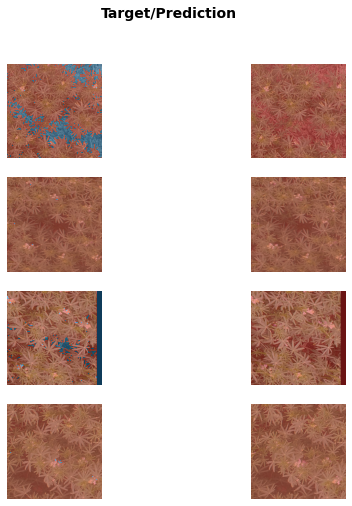

In [11]:
learn.show_results(max_n=4, figsize=(8,8))

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)

# Getting results after kfold test

In [4]:
def label_func(fn):
    path_mask = Path("/data/weed_data/kfold_5ds/labels")
    return path_mask/f"{fn.parent.stem}"/ f"{fn.stem.replace('image', 'mask')}{fn.suffix}"

In [5]:
# Prepare datasets
# Load the data
codes = np.loadtxt("/data/weed_data/inputImages_Masks/codes.txt", dtype='str')
path = Path('/data/weed_data/kfold_5ds/images')

#define the valid idx
a = get_image_files(path, folders=("1","2", "3", "4", "5"))
valid_idx = mask2idxs([i.parent.stem == "1" for i in a])

# load the data
weedt = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                  get_items = get_image_files,
                  get_y = label_func,
                  splitter=IndexSplitter(valid_idx),
                  batch_tfms=Normalize)

# create the data loader
dls= weedt.dataloaders(path, folders=("1","2", "3", "4", "5"), path=path, bs=4)

/home/modanilevicz/.local/lib/python3.8/site-packages/torch/_tensor.py:1051: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  ret = func(*args, **kwargs)


In [6]:
# build the model
learn = unet_learner(dls,
                     resnet18,
                     n_out=3,
                     self_attention=True,
                     normalize=True,
                     pretrained=True,
                     loss_func=DiceLoss(),
                     opt_func=Adam,
                     lr= 0.001,
                     wd=None,
                     metrics=[DiceMulti, JaccardCoeff]).to_fp16()

In [7]:
learn.load('/data/weed_data/model_weights/unet18_1fold_2round')

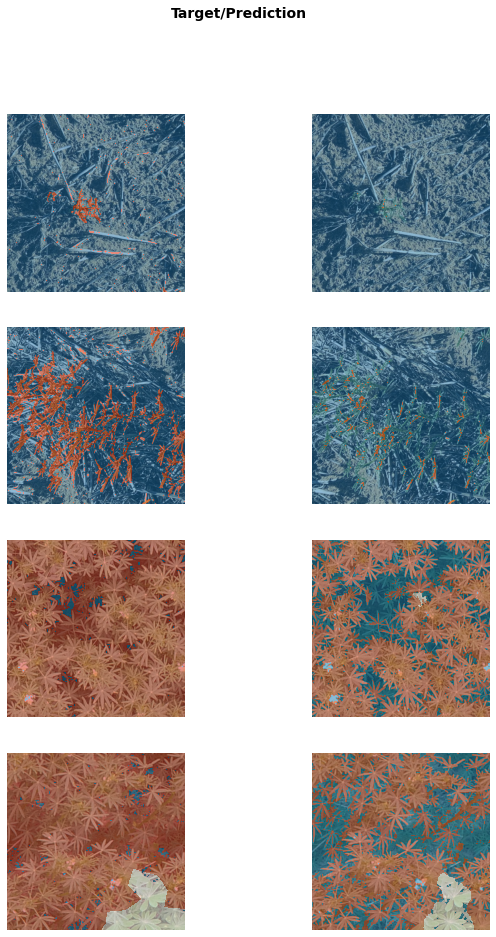

In [9]:
learn.show_results(max_n=6, figsize=(10,15))